In [15]:
import numpy as np
import pandas as pd
import xarray as xr
import pickle
import scipy
from scipy import stats
import matplotlib.pyplot as plt

In [16]:
GCP = pd.read_csv("./../../Prelim_Data_Analysis/gcb_data/budget.csv",
                  index_col=0,
                  usecols=[0,4,5,6]
                 )
GCP.head()

,ocean sink,land sink,budget imbalance
Year,,,
1959,0.852376,0.516073,0.860316
1960,0.819017,1.394030,0.522722
1961,0.714842,0.605098,1.213762
1962,0.756709,1.348349,0.959605
1963,0.904997,0.877794,1.355333


In [17]:
GCP['CO2'] = pd.read_csv("./../co2_temp_data/co2/co2_global.csv", index_col=0, header=0)[2:]
GCP['land sink'] = -GCP['land sink']
GCP['ocean sink'] = -GCP['ocean sink']
GCP['budget imbalance'] = -GCP["budget imbalance"] + GCP['land sink']
GCP.rename(columns={"ocean sink": "ocean",
                    "land sink": "land (model)",
                    "budget imbalance": "land"
                   },
           inplace=True)

In [18]:
GCP.head()

,ocean,land (model),land,CO2
Year,,,,
1959,-0.852376,-0.516073,-1.376389,315.486
1960,-0.819017,-1.394030,-1.916752,316.163
1961,-0.714842,-0.605098,-1.818860,316.856
1962,-0.756709,-1.348349,-2.307954,317.558
1963,-0.904997,-0.877794,-2.233127,318.268


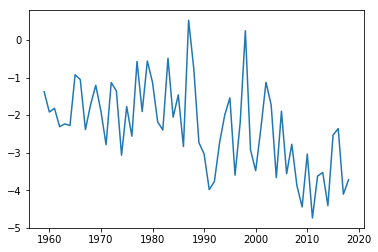

In [5]:
plt.plot(GCP.land)

# Mann-Kendall Test

https://vsp.pnnl.gov/help/Vsample/Design_Trend_Mann_Kendall.htm

Example

In [6]:
# STEP 1
x = np.array([0,3,2,4,3])

In [7]:
# STEP 2

In [8]:
expected_result = [[1,1,1,1], [-1,1,0], [1,1], [-1]]

In [9]:
result = []
for k in range(len(x)):
    sub = []
    for j in range(len(x)):
        if j > k:
            sub.append(np.sign(x[j] - x[k]))
    if len(sub) != 0:
        result.append(sub)

In [10]:
result

[[1, 1, 1, 1], [-1, 1, 0], [1, 1], [-1]]

In [11]:
expected_result == result

True

In [12]:
# create function for step 2
def sgns(x):
    
    result = []
    for k in range(len(x)):
        sub = []
        for j in range(len(x)):
            if j > k:
                sub.append(np.sign(x[j] - x[k]))
        if len(sub) != 0:
            result.append(sub)
    
    return result

In [13]:
sgns(x), sgns(x) == expected_result

([[1, 1, 1, 1], [-1, 1, 0], [1, 1], [-1]], True)

In [14]:
# STEP 4

In [15]:
expected_sum = 4 + 0 + 2 -1
expected_sum

5

In [42]:
np.sum(np.sum(sgns(x))), np.sum(np.sum(sgns(x))) == expected_sum

(5, True)

Now use on GCP

In [62]:
S = np.sum(np.sum(-GCP.land.values))
S

138.8000555325

In [63]:
# STEP 5: n>10
# STEP 6

In [64]:
unique, counts = np.unique(x, return_counts=True)

tied_groups = []
for count in counts:
    if count > 1:
        tied_groups.append(count)
tied_groups

[2]

In [65]:
[i*(i-1)*(2*i+5) for i in t]

[18]

In [66]:
n = len(x)
t = tied_groups
var_s = (1/18)*(n*(n-1)*(2*n+5)) - (1/18)*np.sum([i*(i-1)*(2*i+5) for i in t])
var_s

15.666666666666664

In [67]:
# STEP 7
S, var_s
# S > 0

(138.8000555325, 15.666666666666664)

In [68]:
Z_mk = (S-1)/np.sqrt(var_s)
Z_mk

34.814574446930365

In [69]:
# positive Z_mk means data tends to increase with time.

In [70]:
# STEP 8: null hypothesis


## Function

In [19]:
def S_kendall(data):
    S = 0
    n = len(data)
   
    # Outer sum
    for i in np.arange(0, n - 1):
        # Inner sum
        for k in np.arange(i + 1, n):

            S += np.sign(data[k] - data[i])

    return S


def var_kendall(data):
    unique_vals, count_vals = np.unique(data, return_counts = True)
   
    n = len(data)
    var = n*(n - 1)* (2*n +5)/ 18
   
    if any(count_vals > 1): # there is a repeated value
       
        # These are the number of samples that have been used multiple times
        multi_sampled = count_vals[np.where(count_vals > 1)]
       
        # This following is doing the sum as seen in the varience equation
        summed = 0
        for i in multi_sampled:
            summand = i * (i - 1) * (2 * i + 5)

            summed += summand
           
        # Divided by 18 and subtract from var
       
        var = var - summed / 18
   
    return var


def Z_kendall(S,var):
   
    if S > 0:
        S = S-1
    else:
        S = S+1
       
    Z = S/np.sqrt(var)
   
    return Z


def mann_kendall(data, return_all = False):
   
    # Calculates the s value
    S = S_kendall(data)
   
    # Calculates the varience, does both repeated and non-repeated values
    var = var_kendall(data)
   
    # The z value
    Z = Z_kendall(S,var)
   
    # The p-value form the normal distribution
    p_val = 2 * (1 - stats.norm.cdf(abs(Z)))  # two tail test

   
    # In case I want to check what the z-value is
    if return_all:
        return S, var, Z, p_val
    else:
        return p_val

In [20]:
mann_kendall(-GCP.land.values, return_all=True)

(654.0, 24583.333333333332, 4.164787011055623, 3.1164336024236405e-05)

In [21]:
mann_kendall(-GCP.ocean.values, return_all=True)

(1558.0, 24583.333333333332, 9.930433960510879, 0.0)

In [38]:
x = np.array([0,-1,6,8,44])
mann_kendall(x, True)[2], stats.norm.ppf(1-0.05)

(1.7146428199482247, 1.6448536269514722)

In [39]:
mann_kendall(x, True)[-1], 2*(1-stats.norm.cdf(2))

(0.08641073297370006, 0.04550026389635842)

# Results

Rolling gradient - statistical significance

In [45]:
roll_land = pickle.load(open("./../Output/output_linreg/GCP/roll_df_land.pik", "rb")).values.squeeze()
roll_ocean = pickle.load(open("./../Output/output_linreg/GCP/roll_df_ocean.pik", "rb")).values.squeeze()

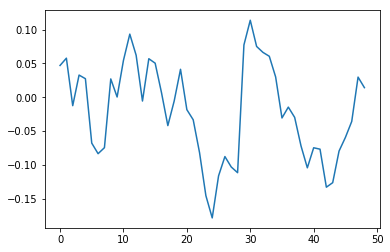

In [52]:
plt.plot(roll_land)

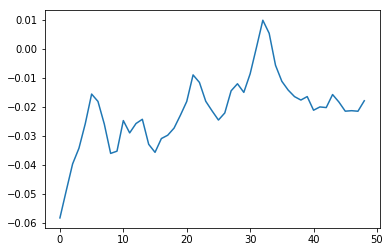

In [66]:
plt.plot(roll_ocean)

In [47]:
mann_kendall(roll_land, True)

(-258.0, 13458.666666666666, -2.215297741974068, 0.026739634741513196)

In [48]:
mann_kendall(roll_ocean, True)

(478.0, 13458.666666666666, 4.1116615677884445, 3.928218324222854e-05)

# Other methods from Stats course

## Stats.linregress

Just use stats.linregress which has a p value calculated from the slope.

From scipy.org:
"Two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero, using Wald Test with t-distribution of the test statistic."

In [64]:
stats.linregress(np.arange(1959,2008), roll_land)[3]

0.04082105318973629

In [65]:
stats.linregress(np.arange(1959,2008), roll_ocean)[3]

1.0570682001171875e-05

## Wald Test

Used by stats.linregress

https://www.statisticshowto.datasciencecentral.com/wald-test/